In [1]:
# 基本moduleのimport
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 基本moduleの設定module
plt.rcParams['font.family'] = "MS Gothic"
plt.style.use("ggplot")
sns.set_theme(context="talk", style="darkgrid", font="MS GOTHIC")

In [2]:
# 出力行数の変更
pd.set_option("display.max_rows", 100)

In [3]:
# データの読み込み
train_df = pd.read_csv("processed/train_pr_sc.csv")
test_df = pd.read_csv("processed/test_pr_sc.csv")
submission_df = pd.read_csv("datasets/sample_submission.csv")

In [4]:
train_df

,id,date,family,onpromotion,year,month,day_of_week,day,is_holidays,oil_price,transactions,sales
0,0,2013-01-01,0.28125,0.000000,0.0,0.000000,0.166667,0.000000,0.0,0.000000,0.000000,0.000
1,1,2013-01-01,0.03125,0.000000,0.0,0.000000,0.166667,0.000000,0.0,0.000000,0.000000,0.000
2,2,2013-01-01,0.18750,0.000000,0.0,0.000000,0.166667,0.000000,0.0,0.000000,0.000000,0.000
3,3,2013-01-01,0.96875,0.000000,0.0,0.000000,0.166667,0.000000,0.0,0.000000,0.000000,0.000
4,4,2013-01-01,0.00000,0.000000,0.0,0.000000,0.166667,0.000000,0.0,0.000000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,0.81250,0.000000,1.0,0.636364,0.166667,0.466667,0.0,0.430031,0.257806,438.133
3000884,3000884,2017-08-15,0.59375,0.001350,1.0,0.636364,0.166667,0.466667,0.0,0.430031,0.257806,154.553
3000885,3000885,2017-08-15,0.93750,0.199730,1.0,0.636364,0.166667,0.466667,0.0,0.430031,0.257806,2419.729
3000886,3000886,2017-08-15,0.15625,0.010796,1.0,0.636364,0.166667,0.466667,0.0,0.430031,0.257806,121.000


In [5]:
test_df

,id,date,family,onpromotion,year,month,day_of_week,day,is_holidays,oil_price,transactions
0,3000888,2017-08-16,0.28125,0.000000,1.0,0.636364,0.333333,0.5,0.0,0.423070,0.252542
1,3000889,2017-08-16,0.03125,0.000000,1.0,0.636364,0.333333,0.5,0.0,0.423070,0.252542
2,3000890,2017-08-16,0.18750,0.002699,1.0,0.636364,0.333333,0.5,0.0,0.423070,0.252542
3,3000891,2017-08-16,0.96875,0.026991,1.0,0.636364,0.333333,0.5,0.0,0.423070,0.252542
4,3000892,2017-08-16,0.00000,0.000000,1.0,0.636364,0.333333,0.5,0.0,0.423070,0.252542
...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,0.81250,0.001350,1.0,0.636364,0.500000,1.0,0.0,0.427228,0.351717
28508,3029396,2017-08-31,0.59375,0.000000,1.0,0.636364,0.500000,1.0,0.0,0.427228,0.351717
28509,3029397,2017-08-31,0.93750,0.001350,1.0,0.636364,0.500000,1.0,0.0,0.427228,0.351717
28510,3029398,2017-08-31,0.15625,0.012146,1.0,0.636364,0.500000,1.0,0.0,0.427228,0.351717


In [6]:
# 説明変数と目的変数に分割
y = train_df["sales"]

X  = train_df.drop(["id", "date", "sales"], axis=1)

X_test = test_df.drop(["id", "date"], axis=1)

In [16]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [17]:
tscv = TimeSeriesSplit(n_splits=5)

In [18]:
# modelを格納するリスト
models = []

# 検証用の予測結果を格納
y_valids = np.zeros((len(X),))

# lightgbmのscoreの保存
val_score = []

# X_testの予測を格納するリスト
preds = []

In [19]:
params = {
    'objective': 'regression',
    'num_leaves': 5,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'reg_alpha': 2,
    'reg_lambda': 30,
    'random_state': 0
}

In [20]:
for train_index, val_index in tscv.split(train_df):
    X_train = train_df.iloc[train_index]
    X_val = train_df.iloc[val_index]

    y_train = X_train["sales"]
    X_train = X_train.drop(["id", "date", "sales"], axis=1)
    y_val = X_val["sales"]
    X_val = X_val.drop(["id", "date", "sales"], axis=1)

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')

     # 予測
    y_valid = model.predict(X_val)
    # 予測を格納
    y_valids[val_index] = model.predict(X_val)
    # スコア
    val_score.append(np.sqrt(mean_squared_error(y_val, y_valid)))

    # テスト用のデータの説明変数で結果を予測
    pred = model.predict(X_test)

    preds.append(pred)

    models.append(model)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 500148, number of used features: 7
[LightGBM] [Info] Start training from score 207.357469
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 1000296, number of used features: 9
[LightGBM] [Info] Start training from score 241.769998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

In [28]:
pred_sales = pd.Series(y_valids, name="pred_sales")
pred_sales

0             0.000000
1             0.000000
2             0.000000
3             0.000000
4             0.000000
              ...     
3000883     468.550088
3000884     102.590814
3000885    2092.813303
3000886      46.840289
3000887      17.532436
Name: pred_sales, Length: 3000888, dtype: float64

In [29]:
y

0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
3000883     438.133
3000884     154.553
3000885    2419.729
3000886     121.000
3000887      16.000
Name: sales, Length: 3000888, dtype: float64

In [31]:
valids_df = pd.concat([y, pred_sales], axis=1)
valids_df

,sales,pred_sales
0,0.000,0.000000
1,0.000,0.000000
2,0.000,0.000000
3,0.000,0.000000
4,0.000,0.000000
...,...,...
3000883,438.133,468.550088
3000884,154.553,102.590814
3000885,2419.729,2092.813303
3000886,121.000,46.840289


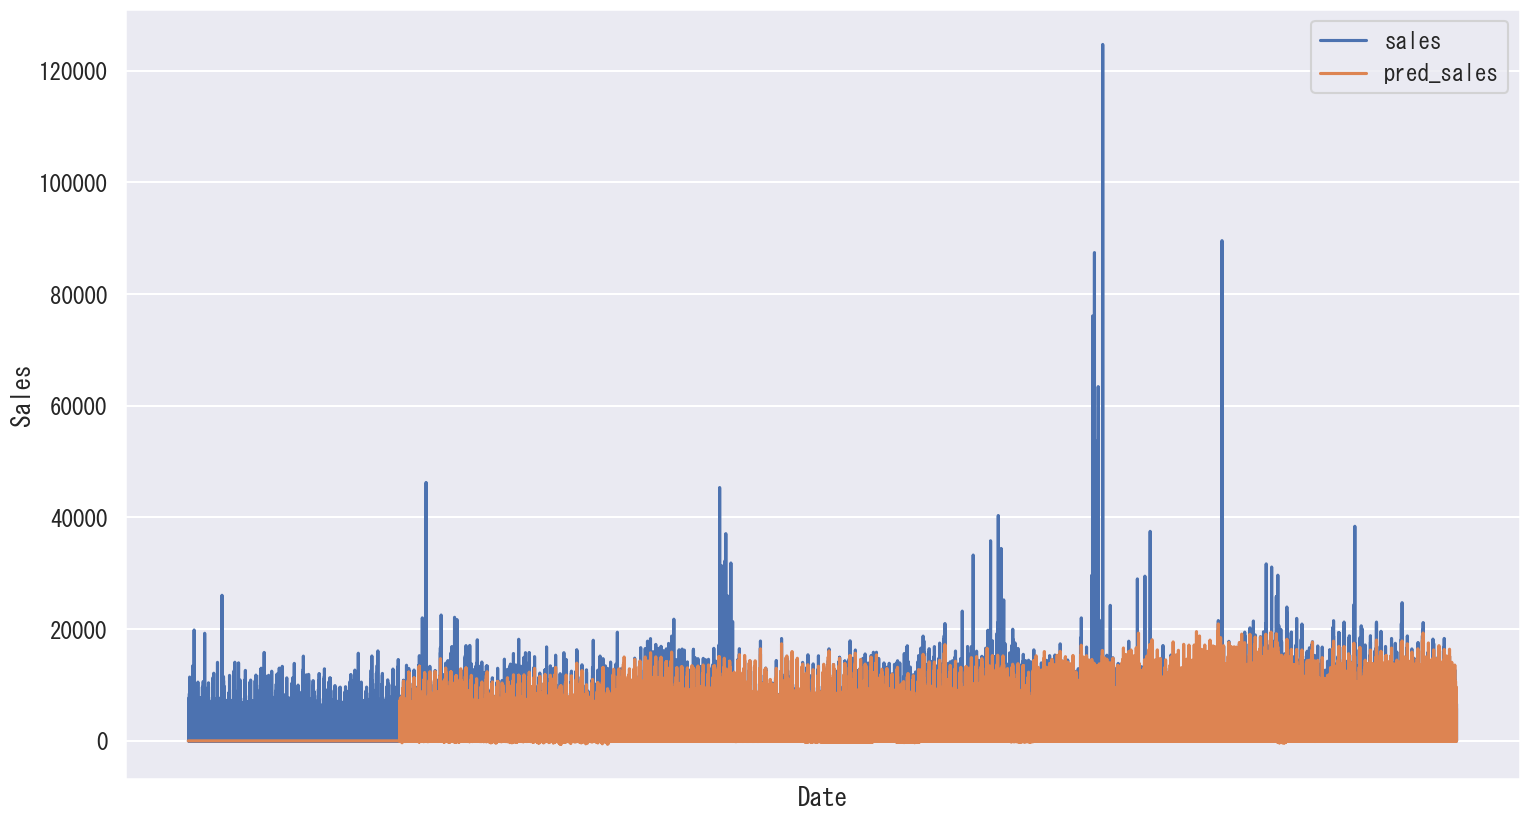

In [32]:
# 可視化
plt.figure(figsize=(18, 10))
sns.lineplot(valids_df, x=valids_df.index, y="sales", label="sales")
sns.lineplot(valids_df, x=valids_df.index, y="pred_sales", label="pred_sales")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.xticks([])
plt.legend()
plt.show()

In [34]:
# 精度の確認
rmse = np.sqrt(mean_squared_error(valids_df["sales"], valids_df["pred_sales"]))
print(f"RMSE:{round(rmse, 2)}")

RMSE:510.56
